In [1]:
from google.colab import drive ; drive.mount("/content/drive") 

Mounted at /content/drive


In [2]:
# Install the Pre Requirements 
"""
Notebook menggunakan Komputasi yang besar dan waktu eksekusi yang lama dikarenakan banyaknya preprocessing dan pembuatan model yang kompleks 
"""
!pip install transformers==3.4.0
!pip install pytypo
!pip install tensorflow==2.2.0 
!pip install Sastrawi
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 1.3MB 8.0MB/s 
     |████████████████████████████████| 1.2MB 32.5MB/s 
     |████████████████████████████████| 890kB 45.9MB/s 
     |████████████████████████████████| 2.9MB 48.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0a4a535d5b8307b10839c2dfc37ac4c9ab2f9be76815845919857fb090c01b1b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 81kB 5.3MB/s 
  Created wheel for pytypo: filename=pytypo-0.3.0-cp36-none-any.whl size=72688 sha256=89842fe85561fb4a79207893a6bb2e4eef8ec5c585a29d587557a52daca34694
  Stored in directory: /root/.cache/pip/wheels/f3/81/55/d305159b9e1631c244110dc3b131b1d0dcf041672dd2e8de9a
Successfully built pytypo
     |████████████████████████████████| 516.2MB 26kB/s 
     |████████████████████████████████| 3.0MB 61.0MB/s 
     |███████████████████████

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import pytypo
from re import sub,compile,UNICODE
import time
from collections import Counter
import transformers
import pickle
import tensorflow_addons as tfa
import nltk 
nltk.download("stopwords");nltk.download("punkt")
import tensorflow as tf
from googletrans import Translator

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud, STOPWORDS 

pd.set_option("max_rows",None)

print(tf.__version__)
print('Keras version: %s' % tf.keras.__version__)
print(f"Transformes {transformers.__version__}")
MAX_LENGTH = 45
AUTO = tf.data.experimental.AUTOTUNE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.2.0
Keras version: 2.3.0-tf
Transformes 3.4.0


In [4]:
# Reading Data
dfTrain = pd.read_csv("/content/drive/My Drive/Dataset/penyisihan-datavidia-7-0/train.csv",sep=",")
dfTest = pd.read_csv("/content/drive/My Drive/Dataset/penyisihan-datavidia-7-0/test.csv",sep=",")

In [ ]:
dfTrain.loc[189]

review_id      fab1cc048d2ae4c985f08d0050b6d995
review_text                           PAYAH !! 
category                                      0
Name: 189, dtype: object

In [ ]:
print(f"Row {dfTrain.shape[0]} \n Col {dfTrain.shape[1]}") # row = 14856, col = 3
print(f"Col Names {dfTrain.columns}") 

Row 14856 
 Col 3
Col Names Index(['review_id', 'review_text', 'category'], dtype='object')


In [ ]:
dfTrain = dfTrain.drop(["review_id"] , axis=1) # Dropped unrelevant columns
dfTrain.head()

,review_text,category
0,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,bocor lagi,0


In [ ]:
print(f"How Many Nulls  ? {dfTrain['category'].isnull().sum()}") # 0
print(f"How Many Values For 1 and 0 \n{dfTrain['category'].value_counts()} ") # Imbalance (0 : 12839, 1 : 2017)


How Many Nulls  ? 0
How Many Values For 1 and 0 
0    12839
1     2017
Name: category, dtype: int64 


In [5]:
def clean_text(text):
  """
  Menhapus Link , Nomor dan mengubah ke lower case juga mengapus spasi tambahan
  """
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+" 
  text_cleaning_num = "(^|\W)\d+"

  
  text = sub(text_cleaning_hash, " ", text).strip()
  text = sub(text_cleaning_num, " ", text).strip()
  text = sub(text_cleaning_re, " ", text).strip()
  text = text.lower().strip()
  text = "".join(text.split("."))  
  out = []
  for word in text.split() :
    out.append(word)

  return pytypo.correct_sentence(" ".join(out).strip())

clean_text("cleaning Gan.. 213213902183 httP:////........ ")

'cleaning gan http'

In [6]:
def clean_emoji(text):

  """ Menghapus Emoji yang ada pada Data Train """
  emoji_patterns = compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=UNICODE)
  return emoji_patterns.sub(r'', text)
print(f"Before :{dfTrain.loc[14492  ,'review_text']}")
clean_emoji(dfTrain.loc[14492  ,"review_text"])

Before :kamarnya sempit, toilet apalagi, water heater y jg ga berfungsi. trus nemuin kelabang di lantai kamar dan di atas kasur, OMG😨😨😨


'kamarnya sempit, toilet apalagi, water heater y jg ga berfungsi. trus nemuin kelabang di lantai kamar dan di atas kasur, OMG'

In [7]:
kamus = {'rpp':"" , 'pjj': "pembelajaran jarak jauh" , "jan" : "jangan" , "emg" : "emang" ,
             "y" : "ya", "lu" : "kamu" , "gue" : "saya" , "gua" : "saya" ,"bkn" : "bukan" , "mksudny" : "maksudnya",
             "gk" : "engga" , "gni" : "gini", "klihatan" : "kelihatan" , "trus" : "terus" ,"beraaa" : "berasa" ,
             "bgt" : "banget","tpi":"tapi","onlen" : "online" ,"yoi" : "ya" , "yooii" : "ya" , "betulll" :"betul",
             "yutub":"youtube" ,"twitt" :"twitter", "bisaa" : "bisa" , "dripada" : "dari pada" , "utk" : "untuk",
             "gegara" :"gara-gara", "donlot" : "mengunduh" ,"w" : "aku" , "dah" : "sudah" , "naek" : "naik",
             "abis" : "habis" , "otw" : "menuju" , "tp" : "tapi" , "bsk" : "besok" , "lg" : "lagi" , "rakan2" : "rekan-rekan" ,
             "mengharungi" : "mengarungi" , "fizikal" : 'fisik',"mangstap" : "mantap" , "bat" : "bener" , "bet" : 'bener',
             "mangat" : "semangat","yg":"yang","sadgurl" : 'perempuan' , "smbil" : "sambil","barbar" : "biadab",
             "ajigggg" : "anjing" , "apaan" : "apa" , "mlooo" : "mulu" , "grgr" : "gara-gara","smt":"semesterr","ttp" :"tetap" ,
             "yok" : "yuk", "beritane" : "beritanya","nurut2" : "nurut-nurut" ,"wa" : 'wassap', 
             "mapel" : "mata pelajaran","ni" : "ini" , "kek" : "kayak","bosen" : "bosan" , "capek" : "cape" ,
             "bego" : "bodoh" , "kagak" : "ngga" , "kesel" : "kesal", "bang" : "mas","ak":"aku" ,"sma" : "sekolah menengah atas",
             "tbtb" :"tiba-tiba","bgt" : "banget","wasaf" : "wassap" ,"anjir":"anjing","ngak" :"nggak",
             "jan" : "jangan","pen" : "pengen" , "offline" : "oflen" , "dasar2nya" : "dasar-dasar nya" , "walhasil" :"hasilnya",
             "semuga" : "semoga","tpi" : "tapi" , "terus2an" : "terus-terus an" , "gaes" : "teman-teman",
             "cm" : "cuma","babay":"selamat tinggal","ntah" : "entah","diruma":"dirumah" , "gtau" : "gatau","anjai" : "anjing",
             "g" : "ngga" , "ad" : "ada" , "samsek" : "sama sekali" , "ppt" : "slide presentasi", "gada" : "ngga ada",
             "quiz" : 'kuis' , "syalan" : "sialan", "puyeng" : "pusing" , "receh" :"tidak menarik","krn":"karena",
             "bget" : "banget" , "quota" : "kouta" , "e learning" : "pembelajaran jarak jauh", "mtk" : "matematika",
             "ansos" : "anti sosial","yutup" : "youtube" , "masalh" : "masalah" , "game" : "permainan","sy":"saya",
             "sprt" : "seperti" , "ketrbtsn" : "keterbatasan" , "kyk" : "seperti" ,"kayak":"seperti","tjukup" : "cukup",
             "bs":"bisa" , "stay" : "menetap" , "cri" : "cari" , "wa" : "wassap" , "ttng" : "tentang","ajg" : "anjing",'sekolah2':'sekolah sekolah',"aing" : "aku","sama2" : "sama-sama" , "kea": "seperti","ato" : "atau","demen":"suka",
             "f2f" : "tatap muka","lgsng" : "langsung","ngirim" : "mengirim","smpe" : "sampai" , "typo" : "salah penulisan",
             "krna" :"karena", "cma" : "cuma","tak" : "tidak","met" :"selamat","miskom" :"salah komunikasi","mager" : "malas",
             "aq":"aku","pgn":"pengen","gada" : "engga ada","mumet":'pusing',
             "@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know",
             "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku",
             "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan",
             "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih",
             "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik",
             "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau",
             "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum",
             "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi",
             "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung",
             "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar"
            , "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget",
             "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana",
             "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh",
             "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar",
             "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong",
             "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru",
             "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa",
             "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia",
             "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat",
             "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar",
             "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal",
             "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang",
             "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep",
             "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi",
             "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall",
             "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek",
             "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka",
             "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta",
             "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu",
             "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari",
             "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh",
             "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu",
             "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri",
             "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back",
             "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas",
             "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi",
             "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas",
             "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana",
             "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini",
             "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya",
             "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", 
             "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan",
             "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong",
             "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah",
             "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion",
             "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja",
             "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam",
             "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar",
             "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau",
             "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan",
             "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah",
             "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya",
             "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional",
             "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau",
             "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa",
             "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan",
             "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian",
             "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus",
             "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya",
             "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman"
             , "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim",
             "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi",
             "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara",
             "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat",
             "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat",
             "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu",
             "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", 
             "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", 
             "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", 
             "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan",
             "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", 
             "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", 
             "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut",
             "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi",
             "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", 
             "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai",
             "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar",
             "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional",
             "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf",
             "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya",
             "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol,psikotropika, dan zat adiktif ",
             "narkoba": "narkotika, psikotropika, dan obat terlarang",
             "nasgor": "nasi goreng", "nda": "tidak",
             "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", 
             "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", 
             "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan",
             "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan",
             "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", 
             "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau",
             "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau",
             "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara",
             "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih",
             "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti",
             "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar",
             "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online",
             "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua",
             "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", 
             "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", 
             "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah",
             "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", 
             "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", 
             "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", 
             "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren",
             "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat",
             "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply",
             "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas",
             "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru",
             "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya",
             "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa",
             "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya",
             "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip",
             "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", 
             "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", 
             "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit",
             "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat",
             "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong",
             "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa",
             "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", 
             "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang",
             "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak",
             "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman",
             "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih",
             "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon",
             "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu",
             "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu",
             "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis",
             "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu",
             "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", 
             "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", 
             "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu",
             "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah",
             "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", 
             "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya",
             "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", 
             "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", 
             "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", 
             "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", 
             "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", 
             "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", 
             "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah",
             "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua",
             "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", 
             "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan",
             "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak",
             "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu",
             "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", 
             "bsk": "besok",'daring' :'online',"bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", 
             "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", 
             "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek",
             "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek",
             "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck",
             "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", 
             "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", 
             "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", 
             "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", 
             "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", 
             "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", 
             "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", 
             "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", 
             "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", 
             "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", 
             "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", 
             "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", 
             "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", 
             "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", 
             "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", 
             "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", 
             "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", 
             "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", 
             "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", 
             "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing",
             "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", 
             "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan",
             "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat",
             "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", 
             "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", 
             "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram",
             "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", 
             "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", 
             "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", 
             "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", 
             "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", 
             "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", 
             "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf",
             "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", 
             "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", 
             "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", 
             "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", 
             "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", 
             "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", 
             "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", 
             "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", 
             "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", 
             "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", 
             "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita",
             "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki",
             "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", 
             "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", 
             "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", 
             "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun",
             "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", 
             "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", 
             "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend",
             "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik",
             "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya",
             "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", 
             "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta",
             "sohib": "teman", "rubahnn": "rubah",'bdk2':'anak anak', "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", 
             "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung",
             "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", 
             "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang",
             "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut",
             "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak",
             "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", 
             "ahokncc": "ahok", "istaa": "nista","aku":"saya",
             "benarjujur": "jujur", "mgkin": "mungkin",'tlp':'telepon','onlineotak':'otak daring','oflen':'luring'  
         ,'cancel':'batal','drpd':'daripada','tgs':'tugas','workfromhome':'bekerja dari rumah','atuser':'','emg':'emang','and':'dan','dha':'dia','kira2':'kira kira','cpt2':'cepat cepat','gmn':'gimana','yg':'yang','dpt':'dapat','jg':'juga','tmn':'teman','tmn2':'teman-teman','tdr':'tidur','byk':'banyak','bgt':'banget','bgtt':'banget','msi':'masih','msh':'masih','emg':'emang','mtk':'matematika','mtkk':'matematika','mtkkk':'matematika','kl':'kalau','ortuku':'orang tuaku','mrk':'mereka','ytb':'youtube','cb':'coba','krn':'karena','hrs':'harus','ndak':'tidak','tiba2':'tiba-tiba','hrs' : 'harus','ak' : 'aku','begimanaaa':'bagaimana','yg' : 'yang','laptoo' : 'laptop','gaada' : 'tidak ada','trus' : 'terus','onlen':'online','ngapsen' : 'mengabsen','dr':'dari','dpt':'dapat','bisa2':'bisa-bisa','yg':'yang','menyulidkan':'menyulitkan','dadi':'jadi','ak':'aku','ajg':'anjing','lg':'lagi','mangstap':'mantap','terossss':'terus','pembeljrn':'pembelajaran','nanya':'tanya','tny':'tanya','tp':'tapi','sblm':'seblum','lgsg':'langsung','ttg':'tentang','oplen':'online','drpd':'daripada','rmh':'rumah','slrh':'seluruh','ketum':'ketua umum','adkel':'adik kelas','mntp':'mantap','r i p':'mati','dahlah':'udahlah','ckuplah':'cukuplah','trs':'terus','kulon':'kuliah online', 'smt':'semester','pulang2':'pulang-pulang','cororong':'corona','notip':'notifikasi','ambis':'ambisi','onlennnn':'online','sm':'sama','ak':'aku','bgt':'banget','mls':'malas','dr':'dari','matlis':'mati listrik','tementemen':'teman-teman', 'udeh':'udah','grgr':'gara gara','jahat2':'jahat jahat','aq':'aku','kulyah':'kuliah','ad':'ada','school':'sekolah','nyusahke':'nyusahkan','irit2':'irit irit','mudeng':'ngerti','paham2':'paham paham','ak':'aku','jingan':'bajingan','ato':'atau','anj':'anjing','mless':'malas','oplen':'offline','class':'kelas','sering2':'sering sering','skul':'sekolah','kelar2':'kelar kelar','gr':'gara','guru2':'guru guru','berbeda2':'berbeda-beda','syg':'sayangku','pinter2':'pinter-pinter','tipsen':'titip absen','gblggg':'goblok','gblg':'goblok','anak2':'anak anak','slm':'selama','anjg':'anjing','pgn':'pengen','oflen':'offline','lama2':'lama-lama','males banget':'sangat malas','mles':'males','teman2':'teman-teman','ajggg':'anjing','ajg':'anjing','ak':'aku','bpk':'bapak','tida':'tidak','bener2':'bener bener','lgi':'lagi','paling burung':'paling buruk','kelen':'kalian','jgn':'jangan','stgh':'setengah','w':'gw','kyk':'kayak','org2':'orang-orang',"bet" : 'bener',"mangat" : "semangat","yg":"yang","sadgurl" : 'perempuan' , "smbil" : "sambil","barbar" : "biadab","ajigggg" : "anjing" , "apaan" : "apa" , "mlooo" : "mulu" ,"grgr": "gara-gara","smt":"semesterr","ttp" :"tetap" ,"yok" : "yuk", "beritane" : "beritanya","nurut2" : "nurut-nurut" ,"wa" : 'wassap', "mapel" : "mata pelajaran","ni" : "ini" , "kek" : "kayak","bosen" : "bosan" , "capek" : "cape" ,"bego" : "bodoh" , "kagak" : "ngga" , "kesel" : "kesal", 'oengen' : 'pengen', 'tyda' : 'tidak', 'yh':'ya','ako' : 'aku', 'lebi' : 'lebih', 'de' : 'deh', 'onlineee' : 'online', 'jd' : 'jadi', 'banya':'banyak','grgr' : 'gara gara', 'ibuk' : 'ibu', 'ppl':'','dom':'domisili','sekaliii':"sekali",'sbg' :'sebagai','org' : 'orang','gblk': 'bodoh','mksd' : 'maksud','gmn':'gimana','sokusinya':'solusinya','anjim':'anjing','flishhh':'plis','kl':'kalau',"betulll" : "betul","yutub":"youtube" ,"twitt" :"twitter", "bisaa" : "bisa" , "dripada" : "dari pada" , "utk" : "untuk","gegara" :"gara-gara", "donlot" : "mengunduh" ,"w" : "aku" , "dah" : "sudah" , "naek" : "naik","abis" : "habis" , "otw" : "menuju" , "tp" : "tapi" , "bsk" : "besok" , "lg" : "lagi" , "rakan2" : "rekan-rekan" ,"mengharungi" : "mengarungi" , "fizikal" : 'fisik',"mangstap" : "mantap" , "bat" : "bener" ,"online" : "onlen" ,"yoi" : "ya" , "yooii" : "ya" , "beraaa" : "berasa" ,"bgt" : "banget","tpi":"tapi","klihatan" : "kelihatan" , "trus" : "terus" , "mksudny" : "maksudnya","gk" : "gak" , "gni" : "gini","us" : "ujian sekolah" , "utbk" : "ujian tulis berbasis komputer" , "ngalong" : "begadang" , "klo" : "kalau" , "please" : "tolong" , "dbuat" : "dibuat" ,"gmna" : "gimana" , "masup" : "masuk" , "nngys" : "nangis" , "goblo" : "bodoh" , "mnding" : "mending" , "aj" : "aja" , "dr" : "dari" ,"gwa" : "aku" , "jg" : "juga" , "tkt" : "takut","samsek" : "sama sekali" , "we" : "aku" , "anjir" : " " , "kerad" : "gila","lg" : "lagi", "tp" : "tapi", "cm" : "cuma", "bs" : "bisa", "prnh" : "pernah","g" : "nggak", "rl" : "real life", "krn" : "karena", "tkt" : "takut", "tmn" : "teman", "jg" : "juga", "hrs" : "harus", "lnjut" : "lanjut", "pjj" : "pembelajaran jarak jauh","trs" : "terus", "scr" : "secara", "nder" : "sender", "lg" : "lagi", "bgt" : "banget", "yg" : "yang", "skr" : "sekarang", "sekul" : "sekolah", "gtu" : "gitu", "gc" : "group chat","mhs" : "mahasiswa", "udh" : "udah", "kl" : "kalo", "gk" : "nggak", "bgst" : "bangsat", "jan" : "jangan", 'pjj': "pembelajaran jarak jauh" , "jan" : "jangan" , "emg" : "emang" ,"y" : "ya", "lu" : "kamu" , "gue" : "aku" , "gua" : "aku" ,"bkn" : "bukan" ,"classes" : "kelas" ,"blm" : "belum" , "classes" : "kelas" ,"blm" : "belum" ,"conference" : "konferensi" , "kadis" : "kepala dinas" , "kabid" : "kepala bidang" , "entah" : "tidak tahu" , "hbis" : "habis", "lupaa" : "lupa" ,"dahlah" : "sudahlah" , "tl" : "timeline" , "prefer" : "lebih memilih" , "gakuat" : "tidak kuat" , "ampunn" : "ampun" , "kampus2" : "kampus-kampus" ,"dpr" : "dewan perwakilan rakyat" , "rapotan" : "raport" , "ky" : "seperti" , "gmn" : "gimana" , "i" : "saya" , "mean" : "maksud" , "blas" : "sama sekali" ,"kasi" : "kasih" , "seneng" : "senang" , "flis" : "tolong" , "gakuad" : "tidak kuat" , "bk" : "besok" , "bbrp" : "beberapa" , "hate" : "benci" ,   "gabut" : "bosan" , "nungguin" : "menunggu" , "nyelesain" : "menyelesaikan" , "pengen" : "mau" ,"skolah" : "sekolah" ,'wth':'apa apaan', "ntar" : "nanti" , "satu2nya" : "satu-satunya" , "ngelawan" : "melawan" , "ena" : "enak" , "statistics" : "statistik" ,"manusya" : "manusia" , "kwad" : "kuat" , "cumanan" : "hanya" , "tmptku" : "tempatku" , "sm" : "sama" , "thx" : "terimakasih" ,"ngapainnnn" : "ngapain" , "lord" : "tuan" , "masi" : "masih" , "nyari" : "mencari" , "gx" : "tidak" , "km" : "kamu" , "gabisa" : "tidak bisa" , "langsungg" : "langsung" , "gada" : "tidak ada" , "kbnykn" : "kebanyakan" , "gtu" : "gitu" , "sfh" : "belajar dari rumah" , "smngt" : "semangat" ,"rewelnya" : "susahnya" ,"sdg" : "sedang" , "thun" : "tahun" , "pemkot" : "pemerintah kota" , "ppdb" : "penerimaan peserta didik baru" , "nakes" : "tenaga kesehatan" ,"lipia" : "lembaga ilmu pengetahuan islam dan arab" , "mulu" : "terus" , "ngingetin" : "mengingatkan" , "unk" : "untuk" , "makasihh" : "terimakasih" ,"td" : "tadi" , "suruu" : "suruh" , "reward" : "penghargaan" , "yak" : "iya" , "un" : "ujian nasional" ,  "ipk" : "indeks prestasi kumulatif" , "iyh" : "iya" , "ngx" : "tidak" , "mo" : "mau" , "pls" : "tolong" , "gatahan" : "tidak tahan" , "msih" : "masih" , "day" : "hari" , "karna" : "karena" , "mageran" : "malas gerak" , "nerapin" : "menerapkan" , "guru2" : "guru-guru" , "cuman" : "hanya" , "betuls" : "betul" , "stay" : "tinggal" , "krucil2" : "anak-anak" , "ngurusinnya" : "mengurusnya" , "matkul" : "mata kuliah" , "gaada" : "tidak ada" , "jl" : "jalan" , "jakpus" : "jakarta pusat" , "for" : "untuk" , "education" : "pendidikan" , "boro" : "jangankan" , "or" : "atau" , "ges" : "guys" , "ad" : "ada" , "muk" : "mau" ,"graphic" : "grafik" , "gaaaa" : "tidak" , "teross" : "terus" , "break" : "istirahat" , "ttep" : "tetap" , "hyung" : "kakak" , "good night" : "selamat malam" , "medsos" : "media sosial" , "tgl" : "tanggal" , "mrah" : "merah" , "ldr" : "hubungan jarak jauh" ,"jd" : "jadi" , "seabreg" : "banyak" ,  "ipk" : "indeks prestasi kumulatif" , "iyh" : "iya" , "ngx" : "tidak" , "mo" : "mau" , "pls" : "tolong" , "gatahan" : "tidak tahan" , "msih" : "masih" , "day" : "hari" , "karna" : "karena" , "mageran" : "malas gerak" ,"gatidur" : "tidak tidur" ,"pantes" : "pantas" , "tdi" : "tadi" , "baek" : "baik" , "berb" : "verb" ,  "bo" : "mau" , "netthink" : "nethink" , "ama" : "sama" , "cicle" : "lingkungan" , "ma" : "sama" , "kaayak" : "seperti" , "yaallah" : "ya allah" , "laen" : "lain" , "nih" : "ini" , "spertinya" : "sepertinya" , "tida" : "tidak" , "kdg" : "kadang" , "b" : "bahasa" , "mauuu" : "mau" , "ato" : "atau" , "apk" : "aplikasi" , "pebisnis" : "pembisnis" , "opo" : "apa" , "ora" : "tidak" , "sabaarrrr" : "sabar" , "jdi" : "jadi" , "tp" : "tapi" , "prepare" : "mempersiapkan" , "halokes" : "sekolah" , "bobo" : "tidur" , "after" : "setelah" , "class" : "kelas" , "cape" : "lelah" , "ngajar" : "mengajar" , "kndisi" : "kondisi" , "spt" : "seperti" , "yth" : "yang terhormat" , "brkontribusi" : "berkontribusi" , "mmberikan" : "memberikan" , "mmbuat" : "membuat" , "tmpt" : "tempat" , "adik2" : "adik-adik" , "skrg" : "sekarang" ,"bnyk" : "banyak" , "blkngan" : "belakangan" , "ttg" : "tentang" , "msk" : "masuk" , "dng" : "dengan" , "mama" : "ibu" , "teacher" : "guru" , "tmn" : "teman" , "mtk" : "matematika" , "met" : "selamat" , "slamat" : "selamat" , "well" : "jadi" , "ampe" : "sampai" , "mantep" : "mantap" , "ujung2nya" : "akhirnya" , "sudahhh" : "sudah" , "agsts" : "agustus" , "ipnya" : "indeks prestasi nya" , "udh" : "udah" , "krs" : "kartu rencana studi" , "smngat" : "semangat" , "5nya" : "5" ,"smg" : "semoga" , "nnti" : "nanti" , 
         "gaenak" : "tidak enak" , "masup" : "masuk" , "ngulang" : "mengulang" , "itung" : "hitung" , "biar" : "supaya" , "kea" : "seperti" , "ak" : "aku" , "hrus" : "harus" , "ap" : "apa" , "dlu" : "dulu" , 
         "gw" : "aku" ,"pake" : "pakai" , "bayangin" : "bayangkan" ,"bikin" : "buat" , "trs" : "terus" , "ujung" : "akhirnya" , "req" : "request" , "bobol" : "menjebol" ,"sikon" : "situasi dan kondisi" , "bnr2" : "benar-benar" , "ready" : "siap" ,"kids" : "anak-anak" , "must" : "harus" , "be safe" : "berhati-hati" , "bantuinn" : "bantuin" , "yaa" : "ya" , "pic" : "picture" ,"they" : "mereka" , "not" : "belum" , 
         "a" : "menjadi seseorang" , "man" : "laki-laki dewasa" , "soale" : "soalnya" ,"assesment" : "penilaian" , "magang2" : "magang" , "bakalan" : "akan" , "mon maap" : "mohon maaf" , "kalo" : "jika" , "gajadi" : "tidak jadi" , "gakan" : "tidak akan" ,"da" : "lah" , "aing" : "saya" , "nyuwun sewu" : "maaf" , "pki" : "partai komunis indonesia" , "sy" : "saya" , "lbh" : "lebih" ,"dl" : "dulu" , "org" : "orang" , "anak2" : "anak-anak" ,"gara2" : "gara-gara" , "napa" : "kenapa" , "malming" : "malam minggu" , "tuh" : "itu" , "tetep" : "tetap" , "pdhal" : "padahal" , "skrang" : "sekarang" , "nggak" : "tidak" , "aja" : "saja" ,"sumpahlah" : "sumpah" , "rto" : "request time out" , "face to face" : "tatap muka" , "online class" : "kelas online" , "gara2" : "gara-gara" , "napa" : "kenapa" ,"kgk" : "tidak" , "dpt" : "dapat" ,"pliss" : "tolong" ,"mapel" : "mata pelajaran" ,"taknak" : "tidak mau" , "stress" : "stres" ,"gausah" : "tidak usah" , "tak" : "tidak" ,"ndek" : "di" , "sampek" : "sampai" , "hp" : "handphone" ,"gabut" : "bosan" , "ngesakno" : "menyusahkan" , "dekne" : "ngrsakno" ,"universiti" : "universitas" ,"ndilok" : "melihat" ,"ngga" : "tidak" , "jelimet" : "rumit" ,"cuba" : "coba" , "nak" : "mau" ,"bnr" : "benar" ,"kek" : "kayak" ,"belii" : "beli" ,"ndak" : "tidak" , "mashok" : "masuk" , "udaa" : "sudah" , "gedeee" : "besar" ,  "worth" : "bernilai" ,"baiknya" : "sebaiknya" , "dr" : "dari" ,"gwe" : "aku" , "from" : "dari" , "home" : "rumah" ,"mrka" : "mereka" , "utk" : "untuk" , "bs" : "bisa" ,"krn" : "karena" ,"g" : "tidak" ,  "mmf" : "maaf" , "klo" : "kalau" , "ad" : "ada" , "bsa" : "bisa" , "dipke" : "dipake" ,"gangerti" : "tidak mengerti" ,"apa2" : "apa-apa" ,"free" : "bebas" , "drmn" : "dari mana" , "rt" : "retweet" , "nsk" : "mau" ,  "cm" : "cuma" , "kayaknya" : "sepertinya" , "tu" : "itu" ,"gegara" : "gara-gara" , "sekaly" : "sekali" ,"btw" : "ngomong-ngomong" , "rada" : "agak" ,"bbrp" : "beberapa" , "nyantol" : "nyangkut" , "drpd" : "daripada" , "ga" : "tidak" , "taun" : "tahun" , "to" : "tryout" , "ptn" : "perguruan tinggi negeri" ,"bareng" : "bareng-bareng" , "semangatt" : "semangat" , "dlm" : "dalam" , "gesss" : "guys" , "smoga" : "semoga" , "la" : "lah" , "aq" : "aku" , "jg" : "juga" , "dgn" : "dengan" , "anjir" : " " ,"skuy" : "yuk" , "mending" : "lebih baik" , "yg" : "yang" ,"ato" : "atau" , "gugel" : "google" , "gamau" : "gak mau" ,"skrng" : "sekarang" ,  "sklh" : "sekolah" , "bgini" : "begini" , "lbh" : "lebih" , "bljr" : "belajar" ,"misqueen" : "miskin" ,"oengen" : "mau" , 'tyda' : "tidak" , "onlen" : "online" ,"menjadu" : "menajdi" , "vc" : "video call" ,  "capek" : "cape" ,"bego" : "bodoh" , "kagak" : "tidak" , "kesel" : "kesal", "mb" : " " ,"dgn" : "dengan" ,"spp" : "sumbangan pembinaan pendidikan" , "gegara" : "gara gara" , "ak" : "aku" , "mbolos" : "bolos" , "aq" : "aku" , "krena" : "karena" ,"nggk" : "enggak" , "ad" : "ada" , "yh" : "ya" , "bkan" : "bukan" , "diy" : "daerah istimewa yogyakarta" , "nder" : "brother" , "tq" : "thank you" , "manala" : "mana yang" ,"yaaa" : "ya" , "thn" : "tahun" , "jgn" : "jangan" ,"syg" : "sayang" , "nambah2" : "nambah-nambah" , "kpn" : "kapan" , "mumet" : "pusing" , "ges" : "guys" , "keja" : "kerja" , "akuu" : "aku" , "tuu" : "itu" , "gituu" : "gitu" , "hengpon" : "handphone" , "dll" : "dan lain-lain" , "murit" : "murid" ,"klayapan" : "kelayapan" , "ngilang" : "hilang" , "gilaaaaa" : "gila" , "ukt" : "uang kuliah tinggal" , "w" : "aku" ,"beritane" : "beritanya" , "nurut2" : "nurut-nurut" , "wa" : "whatsapp" , "mapel" : "mata pelajaran" , "ni" : "ini" , "kek" : "kayak" , "bosen" : "bosan" , "kgn" : "kangen" , "kls" : "kelas" ,"kpai" : "komisi perlindungan anak indonesia" , "gaes" : "guys" , "klian" : "kalian" , "mksdnya" : "maksudnya" , "gimna" : "gimana" ,"riweh" : "ribet" , "ancur" : "hancur" , "brou" : "bro" , "gaenak" : "tidak enak" , "smt" : "semester" , "ttp" :"tetap" ,"yok" : "yuk" ,"mlooo" : "mulu" , "grgr" : "gara-gara" , "smbil" : "sambil" , "barbar" : "biadab" ,"ajigggg" : "anjing" , "apaan" : "apa" ,"lg" : "lagi" , "rakan2" : "rekan-rekan" ,"mengharungi" : "mengarungi" , "fizikal" : "fisik" , "mangstap" : "mantap" , "bat" : "banget" , "bet" : "benar" ,"mangat" : "semangat" , "yg" : "yang" , "sadgurl" : 'perempuan' ,"donlot" : "mengunduh" , "w" : "aku" , "dah" : "sudah" , "naek" : "naik" ,"abis" : "habis" , "otw" : "menuju" , "bsk" : "besok" , "betulll" : "betul","yutub" :"youtube" , "twitt" : "twitter" , "bisaa" : "bisa" , "dripada" : "dari pada" , "utk" : "untuk","gegara" :"gara-gara","trus" : "terus" ,"beraaa" : "berasa" ,"bgt" : "banget" , "tpi" : "tapi" , "onlen" : "online" , "yoi" : "ya" , "yooii" : "ya" ,"gni" : "begini", "klihatan" : "kelihatan" , 'kmtllll':'kontol','pembelajaranjarakjauh':'pembelajaran jarak jauh', 'pjj': "pembelajaran jarak jauh" , "jan" : "jangan" , "emg" : "memang" ,"y" : "ya", "lu" : "kamu" , "gue" : "aku" , "gua" : "aku" , "bkn" : "bukan" , "mksudny" : "maksudnya","gk" : "tidak"  }
      
def applyKamus(text):
  finaltext = []
  for i in text.split(" "):
    if i in kamus.keys():
      word = kamus[i]
      finaltext.append(word)
    else:
      finaltext.append(i)  
    
  return " ".join(finaltext)
applyKamus("aing ga man trs ngulang ngulang")

'saya tidak laki-laki dewasa terus mengulang mengulang'

In [8]:
dfTrain["review_text"] = dfTrain["review_text"].apply(clean_text)
dfTrain["review_text"] = dfTrain["review_text"].apply(clean_emoji)
dfTrain["review_text"] = dfTrain["review_text"].apply(applyKamus)
# Test Set Should not be Preprocessed :) leave it as is
#dfTest["review_text"] = dfTest["review_text"].apply(clean_emoji)
#dfTest["review_text"] = dfTest["review_text"].apply(clean_text)
print("Cleaned")

Cleaned


EDA

In [ ]:
# mengihitung unique seluruh word
UniqueWord = set()
forCounter = []
def Uniques(df):
  for i in range(len(df)):
    Listeddesu = df.loc[i,"review_text"].split(" ")
    for j in Listeddesu:
      UniqueWord.add(j)
      forCounter.append(j)
Uniques(dfTrain)

[Text(0, 0.5, 'counts'),
 Text(0.5, 0, 'Sentiment'),
 Text(0.5, 1.0, 'Jumlah Data Positif dan negatif sentiment')]

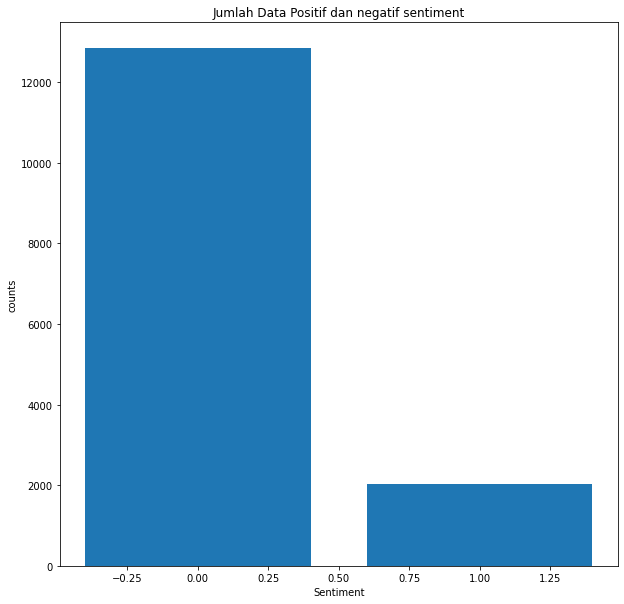

In [14]:
f,ax = plt.subplots(1,1,figsize=(10,10))
uniVal=sorted(dfTrain['category'].unique(),reverse=False)
ax.bar(uniVal, dfTrain["category"].value_counts())
ax.set(title="Jumlah Data Positif dan negatif sentiment",xlabel="Sentiment",ylabel="counts")


array([1, 0])

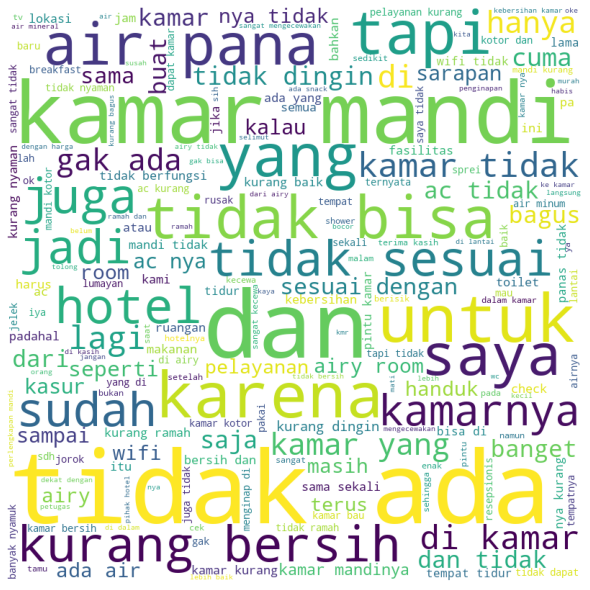

In [ ]:

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in dfTrain["review_text"]: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
print(f"There are : {len(UniqueWord)} words" ) # l

There are : 12561 words


In [ ]:
ShortWord = []
MediumWord = []
# Melihat word Word yang pendek 
def takeShortestword(word):
  for i in word:
    if len(i) < 5:
      ShortWord.append(i)
  for i in word:
    if len(i) > 5 and len(i) < 8 :
      MediumWord.append(i)
takeShortestword(forCounter)
len(ShortWord) ,len(MediumWord)

(85519, 59854)

In [ ]:
UniqueWord = set()
Uniques(dfTrain)
print(f"There are : {len(UniqueWord)} words" )

There are : 12561 words


In [ ]:
ShortWord = sorted(dict(Counter(ShortWord)).items(),key= lambda dct:dct[1],reverse=True)

In [ ]:
#Melakukan Translate pada beberapa Row < Dilakukan untuk membuat model lebih robust terhadap bahasa Indonesia dan bahasa gaul > Namun kami
## meninggalkan beberapa bahasa inggris dan tiddak diubah
## Only 200,000 reqs per day / need to be improved using google cloud api
EnglishRow =[91,199,305,342,388,484,490,561,598,878,895,953,1065,1140,1336,1386,1414,1455,1543,1577,1589,1618,1652,1738,1741,1798,1781,1878,
             1904,1919,1969,2144,2273,2349,2476,2533,2714,2754,2794,2814, 2860, 2859, 2929,2970,2988,3070,3167,3259,3281,3289,3291,3402,3504,3535,3549,3567,
             3606,3610,3620,3638,3647,3697,3743,3893,3932,4080,4140,4185,4215,4220,4270,4382,4430,4521,4534,4607,4662,4678,4696,4716,4725,4738,4765,4766,4787,
             4791,4795,4809,4884,4910,4911,4996,5008,5014,5084,5361,5366,5380,5407,5416,5525,5554,5620,5771,5776,5805,5823,5824,5843,5860,5900,5975,6001,6062,6107,6117
             ,6387,6465,6503,6612,6676,6795,6809,6950,7105,7116,7179,7222,7426,7431,7481,7516,7568,7581,7604,7734,7926,8040,8053,8055,8082,8100,8315,8377,8392,8402,8494,
             8601,8653,8691,8719,8865,9032,9039,9129,9142,9240,9260,9421,9458,9486,9497,9474,9586, 9600,9634,9731,9791,9800,9874,9933,10015,10067,10076,10130,10169,10869,10884,10892,10900,10902,10947,11049,11105,11112,11189,11195,11256,11339,11378,11405,11409,
             11719,11815,11842,11867,11905,11920,11980,12054,12060,12067,12102,12134,12191,12301,12311,12323,12370,
             12376,12390,12406,10237,10245,10269,10335,10348,10435,10520,10566,10729,10753,12550,12656 ,12709 ,12719 ,12822,12980,13039,13104 ,13265 ,13342 ,13349 ,13596 ,13672 ,13732 ,13886,13945,13956,14022, 14073, 14189, 14238, 14301, 14490, 14671, 14678, 14682, 14718, 14731, 14740, 14748, 14812, 14822, 14825, 14840]

def TranslateGan(text):
  # Request
  time.sleep(10)
  translator = Translator()
  ans = translator.translate(text,dest="id")
  print(ans.text)
  return ans.text

for i in EnglishRow:
  dfTrain.loc[i,"review_text"] = TranslateGan(dfTrain.loc[i,"review_text"])

#dfTrain.to_csv("/content/drive/My Drive/EnglishTrain2.csv",index=False)

In [ ]:
checktranslated = [91,199,305,342,388,484,490,561,598,878,895,953,1065,1140,1336,1386,1414,1455,1543,1577,1589,1618,1652,1738,1741,1798,1781,1878,
             1904,1919,1969,2144,2273,2349,2476,2533,2714,2754,2794,2814, 2860, 2859, 2929,2970,2988]
for i in checktranslated:
  print(f'{i} -- > {dfTrain.loc[i,"review_text"]} \n {dfTrain.loc[i,"category"]}')

In [ ]:
dfTrain=pd.read_csv("/content/drive/My Drive/EnglishTrain2.csv")
dfTrain.dropna(inplace=True)
only1 = dfTrain[dfTrain["category"] == 1]
only0 = dfTrain[dfTrain["category"] == 0]
# Melakukan penghapusan pada data dengan kalimat yang membingungkan atau tidak sesuai
for i in only1.index:
  print(f"{i} --> {dfTrain.loc[i,'review_text']}")
deleteonly1 = [53,13736 ,2773,4924,10780,13961,6159,10295,9172,4390,13639,10309,12406,3392,28,646,14715 ,14750 ,14559 ,92,161,13033 ,210,13291 ,317,331,335,12493 ,10087,10306,12101,12253,10623,11275 ,385,4174,6853,7309 ,9331 , 7783 ,8870 , 10007 ,477 ,751 ,854,3993  ,857,3734 ,3718,5546   ,911 ,1080,3026,3962   ,1106 ,1155 ,1519 ,1721 ,1768 ,2361,2425 ,3734]
print(len(only0))

0 --> penginapannya rapi bersih suasana tenang pelayannya ramah dan banyak membantu lokasi cukup dekat ke beberapa obyek wisata kalau saya ke bandung lagi mungkin saya akan menginap lagi di sini
7 --> pelayanannya sangat baik kmr yang bersih menu makanannya juga enak tryout sayang wifinya kutang bagus
12 --> hotel bersih banget nyaman kolam renang bersih pelayanan hotel baik deket sama indomaret depan hotel ada makanan manado murah dan enak remomended banget pokoknya
13 --> roomnya bersih banget lokasi strategis pusat kota nyaman namun pesan yang double bed dapatnya twin bad gempa lombok buat takut menginap di hotel bertingkat
28 --> kamar agak lembab lokasi oke
37 --> disini kami sekeluarga sangat diperhatikan dari kami datang sanpai cek out
39 --> papan nama kurang terlihat kurang besar lokasi pinggir jalan banyak penjual makan pelayanan kebersihan wifi ok sesuai std airy hanya ac kurang dingin
53 --> kamarnya kurang kedap suara jadi suara dari luar mudah terdengar
54 --> tempat dan 

In [ ]:
##
for i in only0.index:
  print(f"{i} --> {dfTrain.loc[i,'review_text']}")
delonly0=[5,24,34,46,69,87,165,181,232,234,249,311,316,345,403,415,481,
      500,530,538,594,636,660,684,696,726,728,753,825,837,856,892,906,924,997,1056,1072,1076,1104,1114,1148,
      1158,1177,1261,1271,1275,1425,1573,1614,1641,1794,2027,2093,2337,2366,2406,2416,2799,2812,2891,2444,1859,2466, 2899,3029,3090,3148 ,
      3157,3161,3235,3300,3314,3339,3342,3397,1549,2385,874,1485,3283]

Streaming output truncated to the last 5000 lines.
9050 --> kamar sangat sempit
9051 --> nyaman sih tapi pas mau booking lagi nambah hari take airy udah gak bisa jadi bayar normal yang jauh lebih mahal dari hrga di airy
9054 --> ac tidak dingin air panas tidak menyala
9056 --> harga rb mahal kamar kecil pengap tidak ada jendela
9058 --> kebersihannya harus ditingkatkan lagi terutama lantai dan sela sela kamar masih kotor dan sepertinya tidak di pel masih banyak debu dan binatang seperti semut
9059 --> shower tidak keluar airnya sudah complain tapi no respon jadi mandi ala kadarnya
9060 --> ruangannya seperti sudah lama tidak terpakai baunya kurang sedap toilet kurang bersih ac kurang dingin untungnya bed nya nyaman jadi masih ada nilai plusnya iya belum bad juga belum tryout good lah terima kasih thats all untuk me
9061 --> kamar sempit sesak
9062 --> kasurnya berdebu sabun toiletnya habis gak di isi
9063 --> saya tidak bisa memberikan ulasan karena pesanan saya tidak saya ambil karena

Hal yang didapat adalah data bersumber dari banyak daerah < ada bali, Surabaya , Hotel juga berbeda beda , Terdapat AIRY >  
Pelabelan data banyak yang tidak tepat  Pendefinisian Label juga tidak diberi tahu < Alasan Pelabelan pada kata kata yang seimbang antara negatif dan positif tidak diberi tahu < Asal Data set tidak diberi tahu . 

Kesimpulan dengan dataset ini < Menghasilkan model bias dan misleading >
Kami Berusaha memperbaiki dataset ini, berhubung dengan waktu yang singkat kami tidak memperbaiki dan crosscheck kembali ditambah kami tidak diberi tahu threshold untuk menentukan sentimen positif maupun negatif.

Pelabelan adalah hal krusial, kembali karena keterbatasan waktu   kami hanya mengeubah beberapa label data saja :)

Ditakutkan juga data test ternyata labelnya seperti ini yang membuat model yang dikembangkan tidak berguna , Kami telah melakukan pendekatan DL maupun ML , melakukan Ensemble juga Menggunakan Powerful Indonesian Deeplearning Model < IndoBert >


In [ ]:
# Index index yang di pertimbangkan untuk pergantia label < TIDAK SEMUA pasti ada yang miss Karena ini bukan tugas seorang data scientist>
addtionchangeto1 = [3344,3426,3423,933,1320,3035,4232,3308,4143,3574]
addtionchangeto0 =  [3070,11103,1911,9254,6064,14566,9925,3199,5663,13877,5059,6230,9554,10709,5525,11271,9421,11730
                    ,6426,4678,2792,9722,12455,1475,10348,11120,14323,4256,11192,1583,6897,14073,11799,6358,5138,14269,7763,7457,9876,4740]


In [ ]:
 # Pengambilan data yang sesuai saja
desiredIndex1 = [i for i in only1.index if i not in deleteonly1]
desiredIndex0 = [i for i in only0.index  if i not in delonly0]
only1 = only1.loc[desiredIndex1] 
only0 = only0.loc[desiredIndex0]
print(len(only1),len(only0))
for i in addtionchangeto1:
  only0.loc[i,"category"] = 1
for i in addtionchangeto0:
  only1.loc[i,"category"] = 0

1956 12738


In [ ]:
only1For1000 = only1 
onlyZero0 = only0[:7000] # Hanya mengambil 7000 data yang labelnya 0

In [ ]:
dfTrain=pd.concat([only1For1000,onlyZero0],axis=0)
dfTrain.dropna(inplace=True)
print(len(dfTrain))

8956


In [ ]:
dfTrain.index = range(len(dfTrain))
def checkLeakageData():
  """ Check Leak data yang mungkin ada di test data """
  leakage = False
  Theindex = []
  for key,val in dfTrain["review_text"].items():
    for key2,val2 in dfTest["review_text"].items():
      if(val == val2):
        leakage=True
        Theindex.append((key,val))
  
  print(f"Leakage ? {leakage}")
  return Theindex


In [ ]:
def RemoveLeakage():
  """ Digunakan untuk menghapus data yang leak ke test data """
  print(len(dfTrain))
  for i in lol:
      dfTrain.loc[i[0]] = np.nan 
  
  dfTrain.dropna(inplace=True)
  print(len(dfTrain))
  

In [ ]:
stopwordsObj = set(stopwords.words("indonesian"))
dfTrain["review_text"] = dfTrain["review_text"].apply(lambda sentence: " ".join(word for word in sentence.split(" ") if word not in stopwordsObj))

In [ ]:
#dfTrain.to_csv("/content/drive/My Drive/PreprocessedData.csv",index=False)

In [ ]:
 # Menghapus Data yang leak < jika ada >
lol = checkLeakageData()
RemoveLeakage()

Leakage ? True
8956
8928


In [ ]:
dfTrain["review_text"].head(10)

0    penginapannya rapi bersih suasana tenang pelay...
1    pelayanannya kmr bersih menu makanannya enak t...
2    hotel bersih banget nyaman kolam renang bersih...
3    roomnya bersih banget lokasi strategis pusat k...
4               sekeluarga diperhatikan sanpai cek out
5    papan nama lokasi pinggir jalan penjual makan ...
6                        kamar bersih harga terjangkau
7    suka tinggal twin star hotel solo rumah pelaya...
8    lokasi hotel pusat keramaian pasar tradisional...
9    having great services strategic locations near...
Name: review_text, dtype: object

MODELLING ML Models

In [ ]:
# Count Vectorizer data Train nya
CountVect = CountVectorizer().fit(dfTrain["review_text"])
training = CountVect.transform(dfTrain["review_text"])
print(training.shape)

(8928, 8794)


In [ ]:
# Melakukan Tfidf pada data Count Vectorizer tadi
TfIdf = TfidfTransformer().fit(training)
training_tfidf = TfIdf.transform(training)

In [ ]:
# Without Using TFIDF
# Melakukan Modelling tidak menggunakan data TFIDF
x_train,x_val,y_train,y_val = train_test_split(training,dfTrain["category"],test_size = 0.10,random_state = 1)
# Define models to train
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]
ThemodelFitted = {}
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(max_depth=45),
    RandomForestClassifier(max_depth=45,n_estimators=250),
    LogisticRegression(),
    SGDClassifier(),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = model
    ThemodelFitted[name] = nltk_model.fit(x_train,y_train)


In [ ]:
from sklearn.model_selection import train_test_split
x_traintfidf,x_valtfidf,y_traintfidf,y_valtfidf = train_test_split(training_tfidf,dfTrain["category"],test_size = 0.10,random_state = 1)

In [ ]:
# Define models to train
# Menggunakan data dengan TFIDF
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]
ThemodelFittedTfidf = {}
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(max_depth=45),
    RandomForestClassifier(max_depth=45,n_estimators=250),
    LogisticRegression(),
    SGDClassifier(),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = model
    ThemodelFittedTfidf[name] = nltk_model.fit(x_traintfidf,y_traintfidf)


Train dan validasi Model ML

In [ ]:
print("Training Gan Without TFIDF")
for name in names:
    predicted = ThemodelFitted[name].predict(x_train)
    print("=========================================")
    print("Using Model {}".format(name))
    print(classification_report(y_train,predicted))
    print("=========================================\n\n")

Training Gan Without TFIDF
Using Model K Nearest Neighbors
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      6293
         1.0       0.89      0.46      0.61      1742

    accuracy                           0.87      8035
   macro avg       0.88      0.72      0.77      8035
weighted avg       0.87      0.87      0.85      8035



Using Model Decision Tree
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      6293
         1.0       1.00      0.88      0.94      1742

    accuracy                           0.97      8035
   macro avg       0.98      0.94      0.96      8035
weighted avg       0.97      0.97      0.97      8035



Using Model Random Forest
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      6293
         1.0       1.00      0.62      0.76      1742

    accuracy                           0.92      8035
   macro avg 

In [ ]:
print("Training Gan With TFIDF")
for name in names:
    predicted = ThemodelFittedTfidf[name].predict(x_traintfidf)
    print("=========================================")
    print("Using Model {}".format(name))
    print(classification_report(y_traintfidf,predicted))
    print("=========================================\n\n")

Training Gan With TFIDF
Using Model K Nearest Neighbors
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91      6293
         1.0       0.91      0.28      0.42      1742

    accuracy                           0.84      8035
   macro avg       0.87      0.63      0.67      8035
weighted avg       0.85      0.84      0.80      8035



Using Model Decision Tree
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      6293
         1.0       1.00      0.87      0.93      1742

    accuracy                           0.97      8035
   macro avg       0.98      0.93      0.96      8035
weighted avg       0.97      0.97      0.97      8035



Using Model Random Forest
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      6293
         1.0       1.00      0.62      0.77      1742

    accuracy                           0.92      8035
   macro avg    

In [ ]:
print("Validation Without Tfidf")
for name in names:
    predicted = ThemodelFitted[name].predict(x_val)
    print("=========================================")
    print("Using Model {}".format(name))
    print(classification_report(y_val,predicted))
    print("=========================================\n\n")

Validation Without Tfidf
Using Model K Nearest Neighbors
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91       709
         1.0       0.74      0.35      0.47       184

    accuracy                           0.84       893
   macro avg       0.79      0.66      0.69       893
weighted avg       0.83      0.84      0.82       893



Using Model Decision Tree
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       709
         1.0       0.65      0.60      0.63       184

    accuracy                           0.85       893
   macro avg       0.77      0.76      0.77       893
weighted avg       0.85      0.85      0.85       893



Using Model Random Forest
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       709
         1.0       0.94      0.42      0.58       184

    accuracy                           0.88       893
   macro avg   

In [ ]:
print("Validation Gan With TFidf")
for name in names:
    predicted = ThemodelFittedTfidf[name].predict(x_valtfidf)
    print("=========================================")
    print("Using Model {}".format(name))
    print(classification_report(y_valtfidf,predicted))
    print("=========================================\n\n")

Validation Gan With TFidf
Using Model K Nearest Neighbors
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90       709
         1.0       0.81      0.21      0.34       184

    accuracy                           0.83       893
   macro avg       0.82      0.60      0.62       893
weighted avg       0.83      0.83      0.78       893



Using Model Decision Tree
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       709
         1.0       0.70      0.61      0.65       184

    accuracy                           0.87       893
   macro avg       0.80      0.77      0.78       893
weighted avg       0.86      0.87      0.86       893



Using Model Random Forest
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       709
         1.0       0.94      0.43      0.59       184

    accuracy                           0.88       893
   macro avg  

Key Take Away : Penggunaan TFIDF Berdampak dengan sangat besar terutama SVM dan SGD classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=45,n_estimators=250),
    LogisticRegression(),
    SGDClassifier(),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = list(zip(names, classifiers))
ThemodelFitted["voting"] = VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1)
ThemodelFitted["voting"].fit(x_train,y_train)

VotingClassifier(estimators=[('K Nearest Neighbors',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('Decision Tree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                          

In [ ]:
print("Without TFIDF")
print("Training Gan")
predicted = ThemodelFitted["voting"].predict(x_train)
print("=========================================")
print("Using Model voting")
print(classification_report(y_train,predicted))
print("=========================================\n\n")

print("Validation Gan")
predicted = ThemodelFitted["voting"].predict(x_val)
print("=========================================")
print("Using Model voting")
print(classification_report(y_val,predicted))
print("=========================================\n\n")

Without TFIDF
Training Gan
Using Model voting
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      6293
         1.0       0.98      0.87      0.92      1742

    accuracy                           0.97      8035
   macro avg       0.97      0.93      0.95      8035
weighted avg       0.97      0.97      0.97      8035



Validation Gan
Using Model voting
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       709
         1.0       0.79      0.68      0.73       184

    accuracy                           0.90       893
   macro avg       0.86      0.82      0.83       893
weighted avg       0.89      0.90      0.89       893





Penggunaan Voting classifier pada Dataset yang tidak menggunakan TFIDF mengahsilakn Model yang overfitting 

In [ ]:
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=45,n_estimators=250),
    LogisticRegression(),
    SGDClassifier(),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = list(zip(names, classifiers))
ThemodelFittedTfidf["voting"] = VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1)
ThemodelFittedTfidf["voting"].fit(x_traintfidf,y_traintfidf)

VotingClassifier(estimators=[('K Nearest Neighbors',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('Decision Tree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                          

In [ ]:
print("With TFIDF")
print("Training Gan")
predicted = ThemodelFittedTfidf["voting"].predict(x_train)
print("=========================================")
print("Using Model voting")
print(classification_report(y_train,predicted))
print("=========================================\n\n")

print("Validation Gan")
predicted = ThemodelFittedTfidf["voting"].predict(x_val)
print("=========================================")
print("Using Model voting")
print(classification_report(y_val,predicted))
print("=========================================\n\n")

With TFIDF
Training Gan
Using Model voting
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      6293
         1.0       0.88      0.84      0.86      1742

    accuracy                           0.94      8035
   macro avg       0.92      0.90      0.91      8035
weighted avg       0.94      0.94      0.94      8035



Validation Gan
Using Model voting
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       709
         1.0       0.75      0.73      0.74       184

    accuracy                           0.90       893
   macro avg       0.84      0.84      0.84       893
weighted avg       0.89      0.90      0.90       893





In [ ]:
testTrainingML = CountVect.transform(dfTest["review_text"])
testTrainingML = TfIdf.transform(testTrainingML)

In [ ]:
predicted = ThemodelFittedTfidf["voting"].predict(testTrainingML)
dfTestMLsubmit = pd.DataFrame(dfTest["review_id"])
dfTestMLsubmit["category"] = predicted.astype("int")
dfTestMLsubmit.head(10)

,review_id,category
0,7302180ac7160f04a405d8aa7bd6beb8,0
1,3184c670e170f565c7522eb76a320ba1,0
2,e33abf6bb5d5a9a77c339043b1725dc8,0
3,061d388950340070a6ac03fabc9027b0,0
4,e62d87c348674b6c06856964f3ab16b8,1
5,22168092df1cee5e8688de966b55d619,0
6,76f40122d394b72f8aaef6631e778d83,0
7,113d82de96ebe4ce173b5bbd0f27a6f3,0
8,d067008752ab449382de2362f0d5dbad,0
9,4cd34d3b3a65d12768149a06a9234bf9,0


In [ ]:
dfTestMLsubmit.to_csv("submitMl.csv",index=False)

Penggunaan Voting classifier pada Dataset yang menggunakan TFIDF mengahsilakn Model yang baik < bisa jadi karena kualitas data itu sendiri >

In [ ]:
## Build the Deep Learning model
from transformers import AutoTokenizer,TFAutoModel,AutoModel
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Untuk deep learning tidak dilakukan preprocessing sperti translate stopword maupun penghapusan dikarenakan
# Metode ini telah robust dengan kata - kata gaul dan telah diperkaya oleh kamus yang besar yaitu INDO 4B
dfTrain = pd.read_csv("/content/drive/My Drive/Dataset/penyisihan-datavidia-7-0/train.csv",sep=",")
dfTrain["review_text"] = dfTrain["review_text"].apply(applyKamus)


from sklearn.model_selection import train_test_split

In [ ]:
x_trainDL,x_valDL,y_trainDL,y_valDL = train_test_split(dfTrain["review_text"],dfTrain["category"],test_size=0.10,random_state=1)
len(x_trainDL), len(y_trainDL)
print(y_val.value_counts())
cp_ytrain = y_train.copy()

0.0    709
1.0    184
Name: category, dtype: int64


In [ ]:
# Tokenizing dataset
tokens_dfTrain = {
    "review_text": tokenizer.batch_encode_plus(
        x_trainDL.tolist(),
        max_length = MAX_LENGTH,
        pad_to_max_length = True,
        truncation = True)
}
tokens_dfVal = {
    "review_text": tokenizer.batch_encode_plus(
        x_valDL.tolist(),
        max_length= MAX_LENGTH,
        truncation=True,
        pad_to_max_length= True
    )

    }
train_data ={
        "review_text": tf.convert_to_tensor(tokens_dfTrain["review_text"]["input_ids"]),
        "review_text_mask":tf.convert_to_tensor(tokens_dfTrain["review_text"]["attention_mask"])
}
val_data = {
        "review_text" : tf.convert_to_tensor(tokens_dfVal["review_text"]["input_ids"]),
        "review_text_mask" : tf.convert_to_tensor(tokens_dfVal["review_text"]["attention_mask"])
}
y_trainDL = tf.convert_to_tensor(y_trainDL)
y_valDL = tf.convert_to_tensor(y_valDL)



y_trainDL = tf.keras.utils.to_categorical(y_trainDL,2)
y_valDL = tf.keras.utils.to_categorical(y_valDL,2)
print(y_trainDL[1:5])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
#create TF Dataset 
dataset = (tf.data.Dataset.from_tensor_slices((train_data,y_trainDL))
.batch(32)
.prefetch(AUTO))

dataVal = (tf.data.Dataset.from_tensor_slices((val_data,y_valDL))
.batch(32)
.prefetch(AUTO)
.cache())

In [ ]:
def CreateDLModel():
  """
  Melakukan PRetrained Model Menggunakan Indo Bert 
  < Indobert architect tidak di train,Hanya beberapa layer output dari Indobert saja yang di train>

  """
  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="review_text")
  att1 = tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="review_text_mask")


  embedding,SeqOutput = IndoBert(ids1,attention_mask=att1)

  finlayer = tf.keras.layers.Dropout(0.4)(embedding)
  finlayer = tf.keras.layers.Dense(128,tf.nn.relu)(finlayer)
  
  finlayer = tf.keras.layers.Flatten()(finlayer)
  theFinal = tf.keras.layers.Dropout(0.55)(finlayer)
  theFinal = tf.keras.layers.Dense(2,activation=tf.nn.softmax)(theFinal)


  final = tf.keras.Model([ids1,att1],[theFinal])
  METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ] 
  
  optimizer = tf.keras.optimizers.Adam()
  final.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(),optimizer=optimizer,
               metrics=METRICS)

  for layer in final.layers:
    layer.trainable = False
  for layer in final.layers[-5:]:
      layer.trainable = True

  return final

models = CreateDLModel()

In [ ]:
import math
def create_learning_rate_scheduler(max_learn_rate=1e-2,
                                   end_learn_rate=1e-6,
                                   warmup_epoch_count=3,
                                   total_epoch_count=15):
    """Membuat Learning Rate Scheduler Agar Training model dapat menyesuaikan dengan luaran operasi matematiknya"""
    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = max_learn_rate
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler

In [ ]:
models.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
review_text (InputLayer)        [(None, 45)]         0                                            
__________________________________________________________________________________________________
review_text_mask (InputLayer)   [(None, 45)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 45, 768), (N 124441344   review_text[0][0]                
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 45, 768)      0           tf_bert_model[0][0]              
______________________________________________________________________________________________

In [ ]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience = 5)

In [ ]:
history3=models.fit(x = dataset,epochs = 20,validation_data=dataVal,callbacks = [EarlyStop, create_learning_rate_scheduler(max_learn_rate=1e-4,
                                                    end_learn_rate=1e-6,
                                                    warmup_epoch_count=3,
                                                    total_epoch_count=15),EarlyStop])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/20
418/418 [==============================] - 55s 131ms/step - loss: 0.3238 - tp: 11304.0000 - fp: 2066.0000 - tn: 11304.0000 - fn: 2066.0000 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.9129 - val_loss: 0.1030 - val_tp: 1394.0000 - val_fp: 92.0000 - val_tn: 1394.0000 - val_fn: 92.0000 - val_accuracy: 0.9381 - val_precision: 0.9381 - val_recall: 0.9381 - val_auc: 0.9757 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/20
418/418 [==============================] - 53s 128ms/step - loss: 0.1537 - tp: 12049.0000 - fp: 1321.0000 - tn: 12049.0000 - fn: 1321.0000 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9584 - val_loss: 0.0661 - val_tp: 1389.0000 - val_fp: 97.0000 - val_tn: 1389.0000 - val_fn: 97.0000 - val_accuracy: 0.9347 - val_precision: 0.9347 - val_recall: 0.9347 - val_auc: 0.9800 - lr: 1.0000e-04

Epoch 00003: LearningRa

In [ ]:
from sklearn.metrics import classification_report
y_valPred = np.argmax(models.predict(dataset),axis = 1)


In [ ]:
y_valTrain = np.argmax(models.predict(dataset),axis = 1)
print(classification_report(np.argmax(y_trainDL,axis = 1),y_valTrain))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     11570
           1       0.85      0.79      0.82      1800

    accuracy                           0.95     13370
   macro avg       0.91      0.88      0.89     13370
weighted avg       0.95      0.95      0.95     13370



In [ ]:
y_valPred = np.argmax(models.predict(dataVal),axis = 1)
print(classification_report(np.argmax(y_valDL,axis = 1),y_valPred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1269
           1       0.83      0.73      0.78       217

    accuracy                           0.94      1486
   macro avg       0.89      0.85      0.87      1486
weighted avg       0.94      0.94      0.94      1486



CrossCheck Luaran Traning Maupun Validasi dari Model IndoBerT

In [ ]:
dfcheck=pd.DataFrame(x_trainDL)
dfcheck["category"] = dfTrain["category"]
dfcheck["pred"] = y_valTrain
lol = dfcheck[dfcheck["category"] != dfcheck["pred"]].index
for i in lol:
  print(f'{i} --> {dfcheck.loc[i,"review_text"]}\n True : {dfcheck.loc[i,"category"]} \n Predicted:{dfcheck.loc[i,"pred"]} \n')


4248 --> kamar kurang bersih baik kamar maupun kamar mandi. tapi pelayanan ramah sarapannya sih mantab. cocok untuk yang backpacker
 True : 0 
 Predicted:1 

10087 --> Masih banyak yang perlu dibenerin lagi. Air hangat, kebersihan ruangan seperti sprei, dan kondisi ba
 True : 1 
 Predicted:0 

11296 --> Harga kaki lima kwalitas bintang lima
 True : 1 
 Predicted:0 

4089 --> lumayan, hanya ruangan agak pengap
 True : 0 
 Predicted:1 

10519 --> lokasi strategis.. sarung bantal dan sprei bau.. handuk lusuh
 True : 0 
 Predicted:1 

6160 --> kamar mandi agar diperbarui, kunci pintu kurang aman
 True : 1 
 Predicted:0 

12531 --> Ruangan yang terlalu gelap membuat kurang nyaman.
 True : 1 
 Predicted:0 

10215 --> Enak bersih, tapi wifinya saja lelet.
 True : 1 
 Predicted:0 

14472 --> ukuran double bed sempit sekali hanya 120 x 200 cm, pengalaman menginap bareng-bareng istri dan anak kesulitan mau tidur nyenyak. untuk fasilitas setara htl melati hrga sesuai dg rasa.
 True : 0 
 Predicte

Terlihat bahwasnya banyak misklasifikasi data training ,namun Model IndoBert dapat mengatasinya dengan baik , Bisa jadi data latihnya juga banyak terjadi kesalahan, hal ini tidak kami betulkan lebih lanjut dikarenakn kami tidak mengetahui threshold labelling dan dasar labelling pada dataset ini, yang memungkinkan data test juga memiliki hal ini < Miss Labelling >

In [ ]:
dfcheck=pd.DataFrame(x_valDL)
dfcheck["category"] = dfTrain["category"]
dfcheck["pred"] = y_valPred
lol = dfcheck[dfcheck["category"] != dfcheck["pred"]].index
for i in lol:
  print(f'{i} --> {dfcheck.loc[i,"review_text"]}\n True : {dfcheck.loc[i,"category"]} \n Predicted:{dfcheck.loc[i,"pred"]} \n')


2202 --> Overal oke, hanya kebersihan kurang menurut saya, ketika saya sarapan peralatan makan kurang bersih, sprei ada noda, dan disini untuk make up room harus titip kunci ke resepsionis dan bilang minta make up room. Kalau tidak, tidak akan dibersihkan.
 True : 1 
 Predicted:0 

2641 --> Nyaman masalahnya hanay di AC yang tidak dingin, perlu di repair sepertinya
 True : 1 
 Predicted:0 

13033 --> Cover bed bantalnya agak bau pesing.
 True : 1 
 Predicted:0 

14625 --> Secara umum bagus. Untuk special request check-in lebih cepat agar bisa diakomodir.
 True : 1 
 Predicted:0 

13447 --> Lumayan, hanya servicenya lambat
 True : 1 
 Predicted:0 

918 --> Lokasi oke, tidak terlalu jauh dari pusat kota. Di bawahnya juga terdapat Indomaret yang ada ATM BCAnya. Kamar nyaman, kasur bersih, perlengkapan lainnya bagus. Namun kekurangannya sambungan Wi-Fi error jadi tidak bisa dipakai sama sekali selama 2 malam saya menginap, wastafel dan WC salurannya bocor, sarapan tidak selalu sedia(harus 

Yep Benar saja , saya sebagai manusia juga kebingunan untuk teks teks dengan pelabelan seperti diatas :) WAjar jika model yang dihasilkan banyak melakukan kesalahan ,dan kadang benar dibandingkan pelabelan yang diberikan

In [ ]:
models.save_weights("/content/drive/My Drive/BestModelNoBs/")

In [ ]:
#models.load_weights("/content/drive/My Drive/BestModelNoBs/")

In [ ]:
# Test ---
# Data test tidak dilakukan preprocessing , karena dapat menyebabkan leak data, maka dari itu kami tidak melakukan preprocessing apapun < kecuali mengubah data agar sesuai dengan inputan model >
"""Mengubah data test agar bisa dilakukan prediksi"""

tokens_dftest = {
    "review_text": tokenizer.batch_encode_plus(
        dfTest["review_text"].tolist(),
        max_length= MAX_LENGTH,
        truncation=True,
        pad_to_max_length= True
    )}

dfTestdataset = {
        "review_text": tf.convert_to_tensor(tokens_dftest["review_text"]["input_ids"]),
        "review_text_mask":tf.convert_to_tensor(tokens_dftest["review_text"]["attention_mask"])
}


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
y_pred = np.argmax(models.predict(dfTestdataset),axis = 1)
y_pred[1:15]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
dfTestAns = pd.DataFrame(dfTest["review_id"])
dfTestAns['category'] =y_pred

In [ ]:
dfTestAns.to_csv("SubmitGanLast.csv",index=False)

In [ ]:
print(dfTestAns["category"].value_counts() )

0    3240
1     474
Name: category, dtype: int64


Overall Kualitas luaran Model Sebenarnya sudah baik Dapat dilihat dari laran modelnya

In [ ]:
dfTestCheck = pd.DataFrame(dfTest["review_text"])
dfTestCheck['category'] = y_pred
Ocat = dfTestCheck[dfTestCheck['category'] == 1].index
for i in Ocat:
  print(f"{i} -- >{dfTestCheck.loc[i,'review_text']}")

4 -- >Lumayan untuk guest house dengan standart harga segitu.
11 -- >So far so good. Bersih.. Nyaman.. AC juga dingin. Aman. Tenang. Cuma kadang toilet nya mampet.
16 -- >Hotel, lokasi dan harga yg sangat nyaman. 
23 -- >Comfortable, clean and tidy Cheap, and recommend
25 -- >kondisi ruangan rapi dan bersih tapi gak tau kenapa bau ruangan  ga enak. tempat makan  dekat dan murah
26 -- >Kamar yang luas, dekat dengan pantai kuta, sebelah ada warung makanan murah dan halal. Minus tidak a
30 -- >Nyaman dan bagus lokasinya mudah di cari.
62 -- >Pelayanan memuaskan, staf ramah, mantap!
66 -- >I think this hotel is very recommended for traveler. The facilities is good enough related the cost.
82 -- >Recommended for backpackers and family traveling
97 -- >Meski agak jauh dari kota tapi tempatnya nyaman untuk menginap...
118 -- >Sangat nyaman dan bersih, betah sekali menginap di kamar tersebut.. 
123 -- >perlu ditingkatkan agar pengunjung merasa nyaman
126 -- >setiap ke surabaya pasti nginap dis

In [ ]:
dfTestCheck = pd.DataFrame(dfTest["review_text"])
dfTestCheck['category'] = y_pred
Ocat = dfTestCheck[dfTestCheck['category'] == 0].index
for i in Ocat:
  print(f"{i} -- >{dfTestCheck.loc[i,'review_text']}")

0 -- >Kasur rusak, punggung saya sakit, kasurnya ga padat, melengkung dan tipis, kecewa
1 -- >gerah
2 -- >tempat ridur atas bawah.. ac nya pararel, tdk ada air panas nya, chanel tv yg kabel nya cina semua, snack nya satu" biasanya dua".. receptionis nya ramah sih
3 -- >ac kurang dingin, tidak ada snack sperti di foto
5 -- >Kurang ramah
6 -- >kurang ramah 
7 -- >sangat mengecewakan. apa yg diberikan tidak seperti yg ditawarkan difoto...foto palsu istirahat jd tidak nyaman krn dibohongi dengan foto kamar yg tidak sesuai...berpikir utk menggunakan airy kembali
8 -- >ngak recomen deh pokoknya
9 -- >TV Tak ada Channel, air kecil
10 -- >tmpt terpencil...susah utk bli mknn
12 -- >sarapannya gak sesuai, katanya nasi goreng . ternyata teh dengan roti
13 -- >handuk cuman dapat 1 parkir bayar nya kemahalan
14 -- >Air bau seng, tidak ada sprei, tidak ada sarung bantal, handuk tidak diganti..
15 -- >Pagi Hari jam 7:15  saat senin, saya mau ke pintu akses keluar dari lobby ternyata masih dikunci dan